In [1]:
%matplotlib inline
%config InlineBackend.figre_formats='svg'

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter('ignore')

sns.set()

In [2]:
# Load the training and test data sets
train_df = pd.read_csv(r'C:\Users\Law Wen Yu\.jupyter\data\cmiyc\train_sessions.csv')
test_df = pd.read_csv(r'C:\Users\Law Wen Yu\.jupyter\data\cmiyc\test_sessions.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
session_id    253561 non-null int64
site1         253561 non-null int64
time1         253561 non-null object
site2         250098 non-null float64
time2         250098 non-null object
site3         246919 non-null float64
time3         246919 non-null object
site4         244321 non-null float64
time4         244321 non-null object
site5         241829 non-null float64
time5         241829 non-null object
site6         239495 non-null float64
time6         239495 non-null object
site7         237297 non-null float64
time7         237297 non-null object
site8         235224 non-null float64
time8         235224 non-null object
site9         233084 non-null float64
time9         233084 non-null object
site10        231052 non-null float64
time10        231052 non-null object
target        253561 non-null int64
dtypes: float64(9), int64(3), object(10)
memory usage: 42.6+ MB


In [4]:
# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df.sort_values(by='time1', inplace=True)
train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54842,54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77291,77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114020,114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146669,146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
# Change site1, ... , site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]

# For the empty sites replace NaN with 0 and change type to int
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load website dictionary
with open(r'C:\Users\Law Wen Yu\.jupyter\data\cmiyc\site_dic.pkl', 'rb') as input_file:
    site_dict = pickle.load(input_file)
    
# Create dataframe for the dictionary
site_dict = pd.DataFrame(list(site_dict.keys()),
                        index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', site_dict.shape[0])
site_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In order to train our first model, we need to prepare the data. First of all, exclude the target variable from the training set. Now both training set and test sets have the same number of columns, and we can aggregate them into one dataframe. Thus, all transformations will be performed simultaneously on oth the training and test datasets. 

In [6]:
# Create the target variable 
y_train = train_df['target']
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test set
idx_split = train_df.shape[0]

For the sake of simplicity, we wil use only the visited websites in the session (and we will not take into account the timestamp features). The point behind this data selection is: Alice has her favorite sites, and the more often you see these sites in the session, the higher the probability that this is an Alice's session, and vice versa.

Let's prepare the data. We will keep only the features site1, site2, ..., site10 in the dataframe.

In [8]:
# Create a new df with only the visited sites
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
21668,56,55,0,0,0,0,0,0,0,0
54842,56,55,56,55,0,0,0,0,0,0
77291,946,946,951,946,946,945,948,784,949,946
114020,945,948,949,948,945,946,947,945,946,946
146669,947,950,948,947,950,952,946,951,946,947


In [9]:
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                               sites_flatten,
                               range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

## Training the first model

Let's build our first model, using logistic regression implementation from Sklearn with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation. Let's write a simple function:

In [10]:
%%time
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,
                           solver='lbfgs', n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]
# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9198622553850316
Wall time: 4.41 s


Correct time-series aware cross validation scheme

In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

time_split = TimeSeriesSplit(n_splits=10)
lr = LogisticRegression(C=1.0, solver='lbfgs',
                       random_state=17).fit(X_train, y_train)

cv_scores = cross_val_score(lr, X_train, y_train, cv=time_split,
                           scoring='roc_auc', n_jobs=-1)
print(cv_scores, np.mean(cv_scores))

[0.84044091 0.67318002 0.862824   0.94439885 0.83021485 0.87687692
 0.92255505 0.86096178 0.92295463 0.91459669] 0.8649003703891269


In [12]:
sample_submission = pd.read_csv(r"C:\Users\Law Wen Yu\.jupyter\data\cmiyc\sample_submission.csv")
sample_submission.head()

,session_id,target
0,1,0.948255
1,2,0.682483
2,3,0.502855
3,4,0.345556
4,5,0.889428


In [13]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                            target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels,
                               index = np.arange(1,
                                                predicted_labels.shape[0] + 1),
                               columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, solver='lbfgs',
                       random_state=17).fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:, :]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

## Feature Engineering + EDA

Let us concentrate on time features:

In [14]:
time_df = pd.DataFrame(index=full_df.index)

time_df['min'] = full_df[times].min(axis=1)
time_df['max'] = full_df[times].max(axis=1)
time_df['minutes'] = round((time_df['max'] - time_df['min']).astype('timedelta64[s]')/60,2)

time_df['start_month'] = time_df['min'].apply(lambda ts: 100 * ts.year + ts.month)
time_df['year'] = time_df['min'].apply(lambda ts: ts.year)
time_df['month'] = time_df['min'].apply(lambda ts: ts.month)

time_df['start_week'] = time_df['min'].apply(lambda ts: 100 * ts.year + ts.week)
time_df['start_day'] = time_df['min'].apply(lambda ts: ts.timetuple().tm_yday)
time_df['start_hour'] = time_df['min'].apply(lambda ts: ts.hour)

time_df['dow'] = time_df['min'].apply(lambda ts: ts.date().weekday())
time_df['is_weekend'] = time_df['min'].apply(lambda ts: 1 if ts.date().weekday() in (5,6) else 0)
time_df['work_hours'] = time_df['min'].apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3))
                                            & ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0)

hour = time_df['min'].apply(lambda ts: ts.hour)
time_df['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
time_df['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
time_df['evening'] = ((hour >=19) & (hour <= 23)).astype('int')
time_df['night'] = ((hour >= 0) & (hour <= 6)).astype('int')

time_df['target'] = y_train
time_df.head()

,min,max,minutes,start_month,year,month,start_week,start_day,start_hour,dow,is_weekend,work_hours,morning,day,evening,night,target
21668,2013-01-12 08:05:57,2013-01-12 08:05:57,0.00,201301,2013,1,201302,12,8,5,1,0,1,0,0,0,0
54842,2013-01-12 08:37:23,2013-01-12 09:07:09,29.77,201301,2013,1,201302,12,8,5,1,0,1,0,0,0,0
77291,2013-01-12 08:50:13,2013-01-12 08:50:17,0.07,201301,2013,1,201302,12,8,5,1,0,1,0,0,0,0
114020,2013-01-12 08:50:17,2013-01-12 08:50:20,0.05,201301,2013,1,201302,12,8,5,1,0,1,0,0,0,0
146669,2013-01-12 08:50:20,2013-01-12 08:50:22,0.03,201301,2013,1,201302,12,8,5,1,0,1,0,0,0,0


Now, we can begin our exploratory data analysis. Let us first observe weekday countplots:

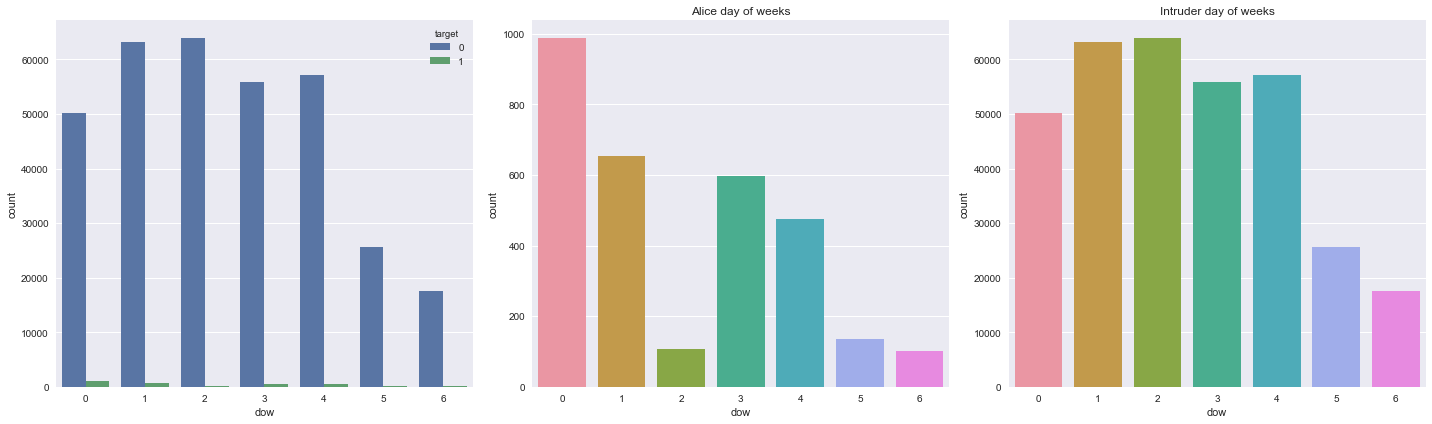

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
sns.countplot(x='dow', hue='target', data=time_df, ax=ax1)

sns.countplot(x='dow', data =time_df[time_df['target']==1], ax=ax2)
ax2.set_title('Alice day of weeks')

sns.countplot(x='dow', data=time_df[time_df['target']==0], ax=ax3)
ax3.set_title('Intruder day of weeks')

plt.tight_layout()

Now, let us observe start hour percentages for Alice and Intruder. We will result in a similar decision. Starting hour is reconizable for Alice behavior.

KeyboardInterrupt: 

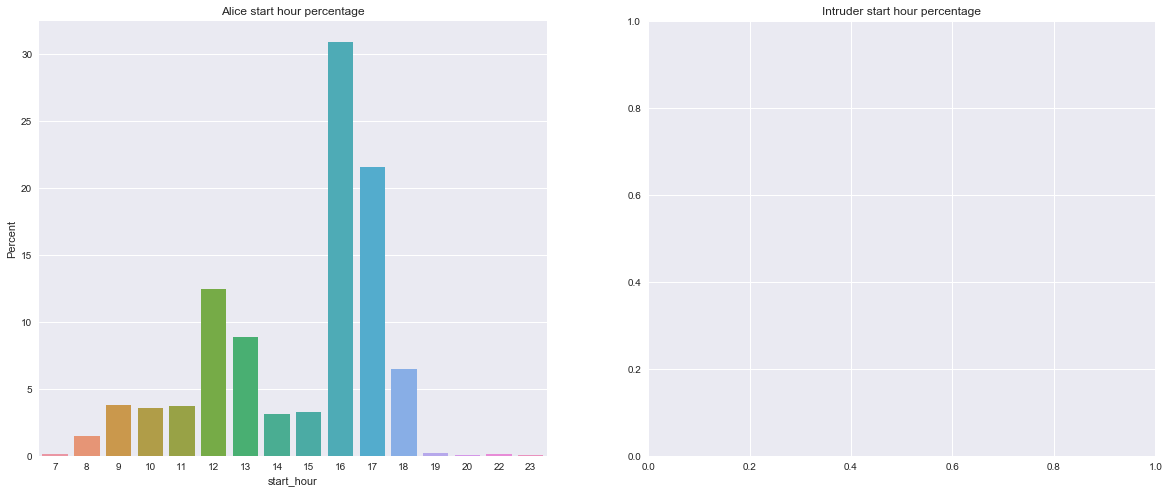

In [16]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Alice start hour percentage')
ax =sns.barplot(x="start_hour", y="start_hour", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title('Intruder start hour percentage')
ax =sns.barplot(x="start_hour", y="start_hour", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

Let us observe Alice's activity among day of years. Seems like Alice is not active at all.

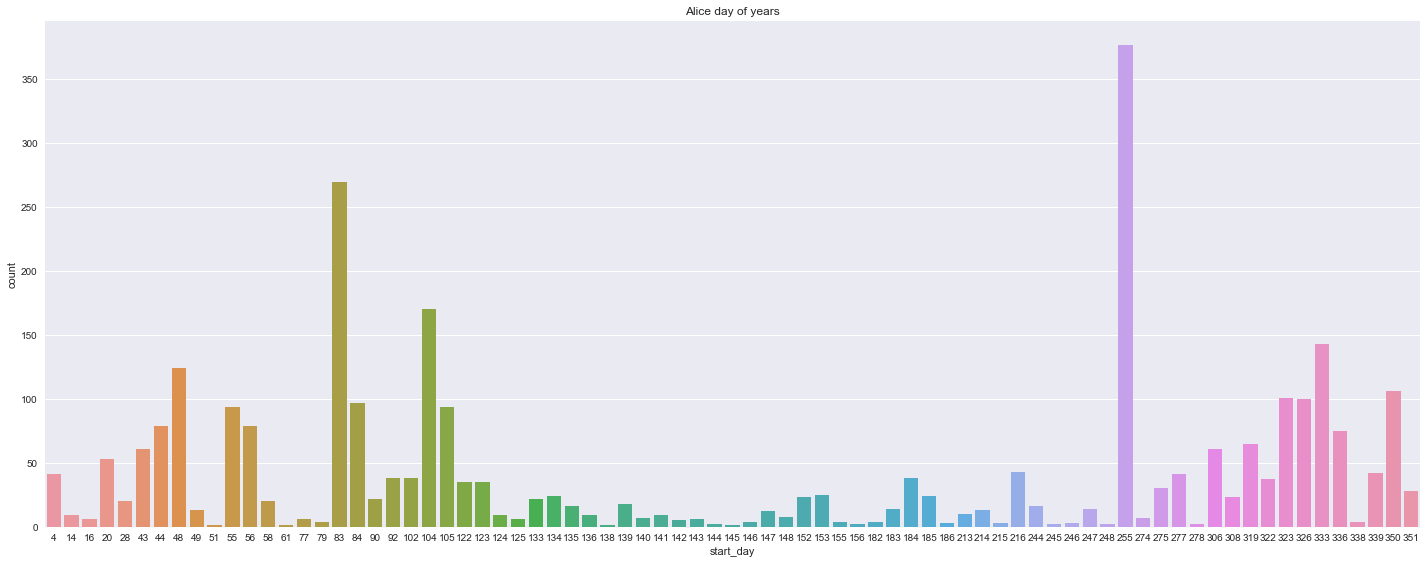

In [275]:
fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('Alice day of years')
sns.countplot(x='start_day', data=time_df[time_df['target']==1], ax=ax)
plt.tight_layout()

We may indeed have useless features for now.. See below that 'start_week' and 'year' features are highly correlated with start_month feature.

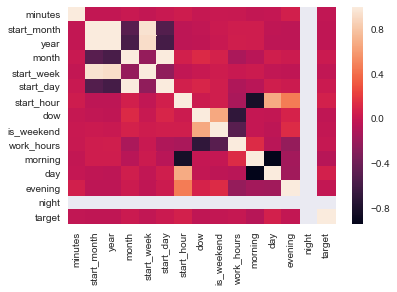

In [426]:
sns.heatmap(time_df.corr())

Now we will make use of a more useful feature about the time spent in sessions than previosly set 'seconds' feature: 'minutes'. If we look at minutes spent in sessions, we may better classify the session periods.

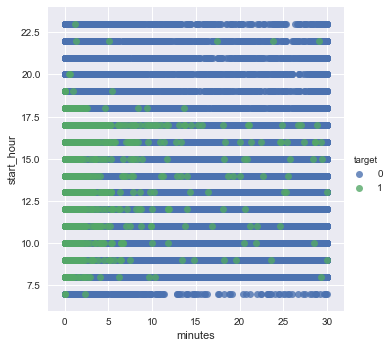

In [277]:
sns.lmplot('minutes', 'start_hour', data=time_df, hue='target', fit_reg=False)

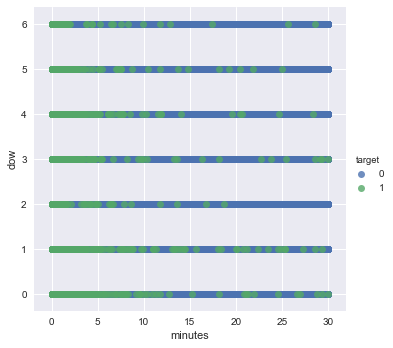

In [278]:
sns.lmplot('minutes', 'dow', data=time_df, hue='target', fit_reg=False)

The below plots also show the yearly activities for Alice and Intruder

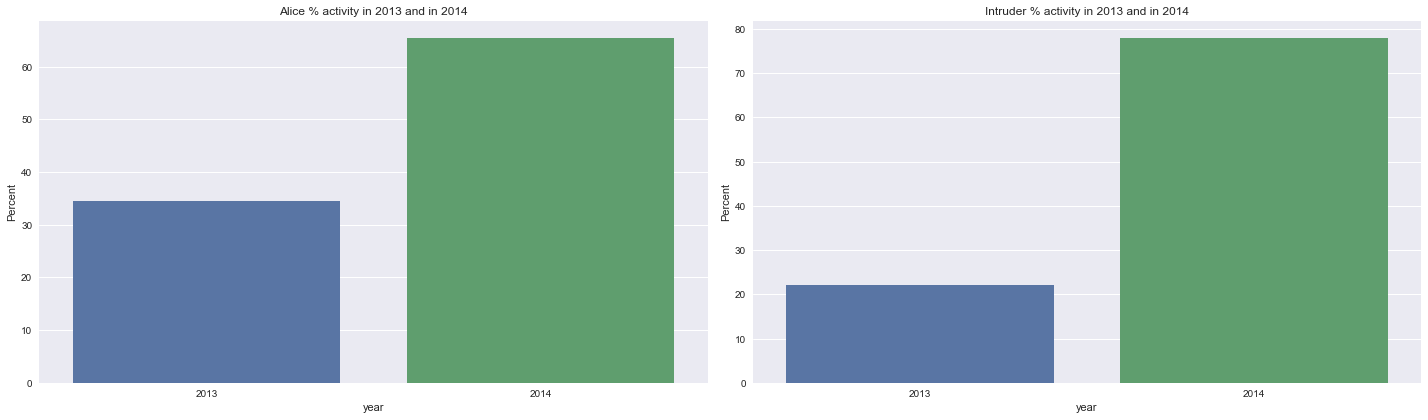

In [280]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.title('Alice % activity in 2013 and in 2014')
ax =sns.barplot(x="year", y="year", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")
plt.subplot(1,2,2)
plt.title('Intruder % activity in 2013 and in 2014')
ax =sns.barplot(x="year", y="year", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

Finally, we will observe monthly behaviours;

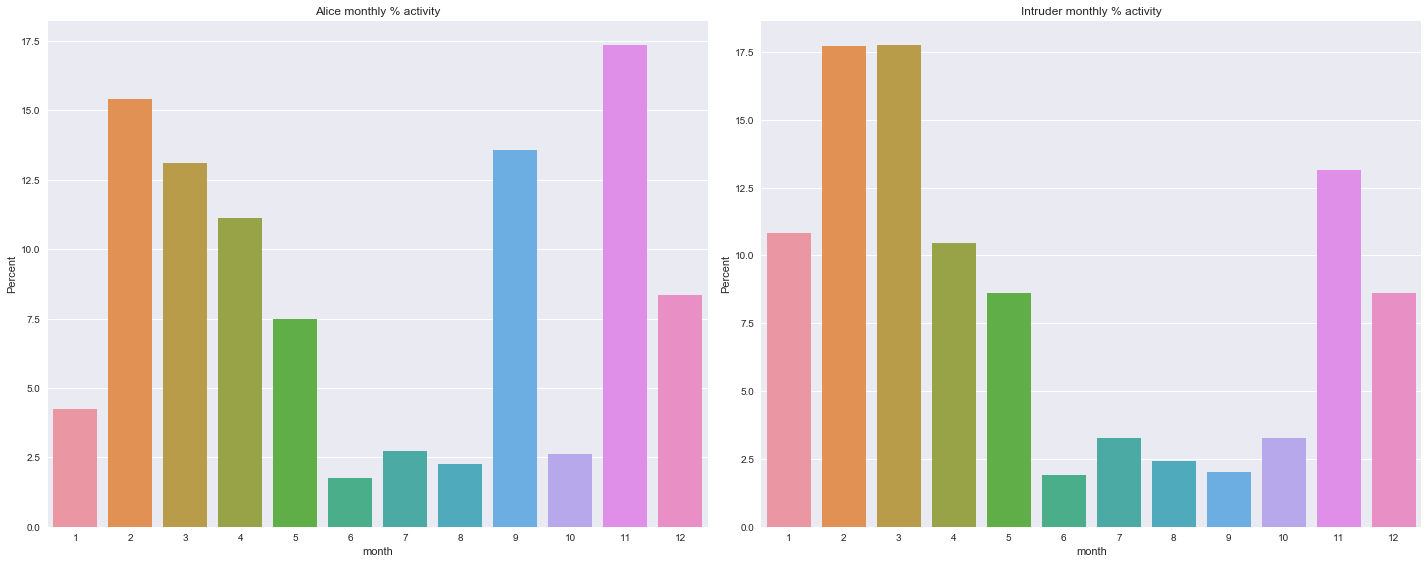

In [281]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title('Alice monthly % activity')
ax =sns.barplot(x="month", y="month", data=time_df[time_df['target']==1], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==1]) * 100)
ax.set(ylabel="Percent")
plt.subplot(1,2,2)
plt.title('Intruder monthly % activity')
ax =sns.barplot(x="month", y="month", data=time_df[time_df['target']==0], 
                 estimator=lambda x: len(x) / len(time_df[time_df['target']==0]) * 100)
ax.set(ylabel="Percent")
plt.tight_layout()

From our exploration, it seems like we have discovered a few variables that could potentially improve our model. They include 'minutes', 'start_hour', 'dow' and 'year'. 

Now, let's try applying a standard scaler to these variables, before we will add them into our training data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Create an index to pick out the four variables that we are interested in
data_add = ['minutes', 'start_hour', 'dow', 'year']
new_data = time_df[data_add]

# Use the function StandardScaler on them
scaler = StandardScaler()
new_data[data_add] = scaler.fit_transform(new_data[data_add])

In [ ]:
from scipy.sparse import hstack

# Add our new features to the existing full sparse matrix
m = np.matrix(new_data[data_add])
full_sites_sparse1 = hstack([full_sites_sparse, m], format='csr')

In [ ]:
%%time
# Seperate our training set 
X_train1 = full_sites_sparse1[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train1, y_train))

In [ ]:
# Correct time aware cross validation
cv_scores = cross_val_score(lr, X_train1, y_train, cv=time_split,
                           scoring='roc_auc', n_jobs=-1)

print(cv_scores, cv_scores.mean())

As we can see, adding these four features into our variable space vastly improved our performance! Our ROC-AUC score has increased from 0.920 to 0.967 for the simple holdout set evaluation, and increased from 0.865 to 0.906 for the correct time aware cross validation!

Now, let's create our submission for Kaggle!

In [19]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, solver='lbfgs',
                       random_state=17).fit(X_train1, y_train)

# Make a prediction for test data set
X_test1 = full_sites_sparse1[idx_split:, :]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_5.csv')

ValueError: X has 48371 features per sample; expecting 48375

Note that we have yet to optimize our hyperparemeters for our logistic regression. In the next section, we shall explore ways to optimize our logistic regression!

## Hyperparameters optimization

We shall start by using GridSearchCV.

In [23]:
# %%time
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-2, 2, 10)}

grid_logit = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc',
                          n_jobs=-1, verbose=True) 
grid_logit.fit(X_train1, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [24]:
print(grid_logit.best_params_, grid_logit.best_score_)

{'C': 1.6681005372000592} 0.9016139311676271


Now, let's perform the correct time-aware cross-validation scheme

In [ ]:
time_split = TimeSeriesSplit(n_splits=10)

Now, we tune the regularization parameter C using the correct time aware cross-validation scheme.

In [ ]:
%%time
param_grid = {'C': np.logspace(-2, 2, 50)}

logit_grid_searcher = GridSearchCV(lr, param_grid=param_grid,
                                  scoring='roc_auc', n_jobs=-1,
                                  cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train1, y_train)

In [ ]:
print(logit_grid_searcher.best_params_, logit_grid_searcher.best_score_)

Our hyperparameters tuning has gotten us a slightly better score at 0.9064 vs 0.9063!

Now, let's use this tuned parameter and submit it to Kaggle!

In [ ]:
y_test = logit_grid_searcher.predict_proba(X_test1)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_6.csv')

Yay, our model scored 0.92278, an improvement of our previous score of 0.91307. Well done!

## A different set of features

Now, let's try it out with a different set of inputs. In this case, we will use minutes, dow, year, morning, day, evening and night. 

In [17]:
data_add1 = ['minutes', 'morning', 'day', 'evening', 'night']
new_data1 = time_df[data_add1]

scaler = MinMaxScaler()
new_data1['minutes'] = scaler.fit_transform(new_data1['minutes'].reshape(-1,1))
new_data1.head()

NameError: name 'MinMaxScaler' is not defined

In [ ]:
m1 = np.matrix(new_data1[data_add1])
full_sites_sparse2 = hstack([full_sites_sparse, m1], format='csr')

In [ ]:
%%time

X_train2 = full_sites_sparse2[:idx_split, :]
lr2 = LogisticRegression(C=1.0, solver='lbfgs',
                       random_state=17).fit(X_train2, y_train)

cv_scores = cross_val_score(lr2, X_train2, y_train, cv=time_split,
                           scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

Using this set of new features has vastly improved our performance from 0.906 to 0.916.

Next, let's tune the parameters.

In [32]:
%%time

param_grid = {'C': np.logspace(-2, 2, 50)}

logit_grid_searcher1 = GridSearchCV(lr2, param_grid=param_grid,
                                  scoring='roc_auc', n_jobs=-1,
                                  cv=time_split, verbose=1)

logit_grid_searcher1.fit(X_train2, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


Wall time: 6min 35s


In [33]:
print(logit_grid_searcher1.best_params_, logit_grid_searcher1.best_score_)

{'C': 0.42919342601287763} 0.9160386798678429


In [34]:
X_test2 = full_sites_sparse2[idx_split:, :]
y_test = logit_grid_searcher1.predict_proba(X_test2)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_7.csv')

## Let's create a new set of features

From our exploratory data analysis, we have seen that the length of the session and Alice's day of week usage is different from the intruder. We shall now attempt to engineer these features before feeding into the predictive system once again.

We shall create three different features based on length of the session. Short <= 1 minutes, Long >1 minutes. We shall also seperate the day of week in Monday, Tuesday, Wednesday, Thursday, Friday, Saturday & Sunday.

In [18]:
# Segregrate based on the length of the session
short = (time_df['minutes'] <= 1).astype('int')
long = (time_df['minutes'] > 1).astype('int')

# Segregrate based on day of week
mon = (time_df['dow']==0).astype('int')
tue = (time_df['dow']==1).astype('int')
wed = (time_df['dow']==2).astype('int')
thurs = (time_df['dow']==3).astype('int')
fri = (time_df['dow']==4).astype('int')
sat = (time_df['dow']==5).astype('int')
sun = (time_df['dow']==6).astype('int')

# Segregrate based on month
jan = (time_df['month']==1).astype('int')
feb = (time_df['month']==2).astype('int')
mar = (time_df['month']==3).astype('int')
apr = (time_df['month']==4).astype('int')
may = (time_df['month']==5).astype('int')
june = (time_df['month']==6).astype('int')
july = (time_df['month']==7).astype('int')
aug = (time_df['month']==8).astype('int')
sep = (time_df['month']==9).astype('int')
oct = (time_df['month']==10).astype('int')
nov = (time_df['month']==11).astype('int')
dec = (time_df['month']==12).astype('int')

(-1, 7)

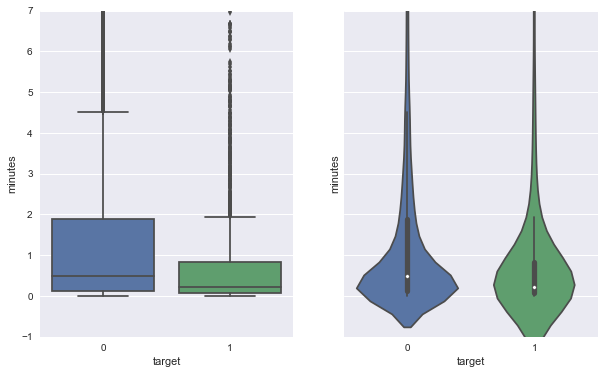

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), sharey=True)
sns.boxplot(x='target', y='minutes', data=time_df, ax=ax1)
sns.violinplot(x='target', y='minutes', data=time_df, ax=ax2)
ax1.set_ylim(-1,7); ax2.set_ylim(-1,7)

In [20]:
m1 = np.matrix(time_df[['morning', 'day', 'evening', 'night']])
m2 = np.matrix([short, long, mon, wed]).T

full_sites_sparse3 = hstack([full_sites_sparse, m1, m2], format='csr')

Now, let's perform the correct time aware cross validation method and see what our score is. 

In [21]:
%%time

X_train3 = full_sites_sparse3[:idx_split, :]
lr3 = LogisticRegression(C=1.0, solver='lbfgs',
                       random_state=17).fit(X_train3, y_train)

cv_scores = cross_val_score(lr3, X_train3, y_train, cv=time_split,
                           scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[0.90090407 0.82493186 0.93542211 0.98030915 0.91638232 0.96429356
 0.94761424 0.9524711  0.88340873 0.96214698] 0.9267884108281079
Wall time: 16.7 s


In [22]:
%%time

param_grid = {'C': np.logspace(-2, 2, 10)}

logit_grid_searcher2 = GridSearchCV(lr3, param_grid=param_grid,
                                  scoring='roc_auc', n_jobs=-1,
                                  cv=time_split, verbose=1)

logit_grid_searcher2.fit(X_train3, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Wall time: 1min 24s


In [23]:
logit_grid_searcher2.best_params_, logit_grid_searcher2.best_score_

({'C': 0.21544346900318834}, 0.9259545782348376)

In [47]:
X_test3 = full_sites_sparse3[idx_split:, :]
y_test = logit_grid_searcher2.predict_proba(X_test3)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_13.csv')